In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensordash.tensordash import Tensordash
import tensorflow as tf
import time

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session =tf.compat.v1.InteractiveSession(config=config)

# Data preprocessing

In [3]:
table=pd.read_csv("fer2013.csv").values
x=list()
for i in range(table.shape[0]):
    table[i][1]=np.uint8(np.asarray(table[i][1].split(' ')).reshape((48,48)))
    im=table[i][1]
    im=cv2.resize(im,(96,96))
    im=cv2.cvtColor(im,cv2.COLOR_GRAY2BGR)
    x.append(im)
    print("Current row : %d"%i,end="\r")
print("\nDone!")
table=table[:,:-1]
x=np.asarray(x)
y=np.uint8(table[:,0])
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
y = onehot_encoder.fit_transform(y.reshape(-1,1))
xtrain=x[:28709,:,:,:]
xtestpub=x[28709:32298,:,:,:]
xtestpri=x[32298:,:,:,:]
ytrain=y[:28709,:]
ytestpub=y[28709:32298,:]
ytestpri=y[32298:,:]
np.save("xtrain.npy",xtrain)
np.save("ytrain.npy",ytrain)
np.save("xtestpri.npy",xtestpri)
np.save("ytestpri.npy",ytestpri)
np.save("xtestpub.npy",xtestpub)
np.save("ytestpub.npy",ytestpub)

Current row : 35886
Done!


In [3]:
xtrain=np.load("xtrain.npy")
ytrain=np.load("ytrain.npy")
xtestpri=np.load("xtestpri.npy")
ytestpri=np.load("ytestpri.npy")
xtestpub=np.load("xtestpub.npy")
ytestpub=np.load("ytestpub.npy")

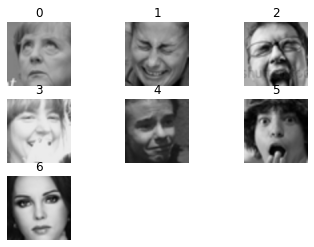

In [4]:
fig=plt.figure()
for i in range(7):
    ax=fig.add_subplot(3,3,i+1)
    ax.set_title(str(i))
    ax.axis('off')
    temp=random.randint(0,xtrain[ytrain[:,i]==1].shape[0]-1)
    ax.imshow(np.uint8(xtrain[ytrain[:,i]==1][temp]),cmap='gray')
plt.show()

In [5]:
xtrain=preprocess_input(xtrain)
xtestpub=preprocess_input(xtestpub)
xtestpri=preprocess_input(xtestpri)

# Model declaration

In [6]:
resnet=MobileNetV2(weights='imagenet', include_top=False, input_shape=(xtrain.shape[1],xtrain.shape[2],3))
#resnet.summary()

In [7]:
# model.add(Input(shape=(48,48,1)))
# model.add(Conv2D(filters=3,kernel_size=3,padding='same'))
for layer in resnet.layers:
    layer.trainable = False
resnet.trainable=False
mx=GlobalAveragePooling2D()(resnet.output)
mx=Dense(2048,activation='relu')(mx)
mx=Dense(ytrain.shape[1],activation='softmax')(mx)
model=Model(resnet.input,mx)

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 6, 6, 64)     12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 6, 6, 64)     256         block_6_project[0][0]            
__________________________________________________________________________________________________
block_7_expand (Conv2D)         (None, 6, 6, 384)    24576       block_6_project_BN[0][0]         
__________________________________________________________________________________________________
block_7_expand_BN (BatchNormali (None, 6, 6, 384)    1536        block_7_expand[0][0]             
__________________________________________________________________________________________________
block_7_expand_relu (ReLU)      (None, 6, 6, 384)    0           block_7_expand_BN[0][0]    

# Model Performance Trackers

In [8]:
tensorboard=TensorBoard(log_dir="log/%f"%(time.time()))
tensorboard.set_model(model)

In [9]:
histories=Tensordash(email='sagnik106@gmail.com', ModelName='Facial Emotion Recognition')

# Training

In [10]:
with tf.device('/gpu:0'):
    history=model.fit(xtrain,ytrain,epochs=50,batch_size=32,validation_data=(xtestpub,ytestpub),shuffle=True,verbose=1,callbacks=[tensorboard, histories])

Epoch 1/50
898/898 [==============================] - 15s 17ms/step - loss: 1.5941 - accuracy: 0.3821 - val_loss: 1.4943 - val_accuracy: 0.4218
Epoch 2/50
898/898 [==============================] - 14s 16ms/step - loss: 1.4412 - accuracy: 0.4548 - val_loss: 1.4344 - val_accuracy: 0.4436
Epoch 3/50
898/898 [==============================] - 15s 16ms/step - loss: 1.3799 - accuracy: 0.4807 - val_loss: 1.3996 - val_accuracy: 0.4609
Epoch 4/50
898/898 [==============================] - 14s 16ms/step - loss: 1.3369 - accuracy: 0.4987 - val_loss: 1.3792 - val_accuracy: 0.4692
Epoch 5/50
898/898 [==============================] - 14s 16ms/step - loss: 1.3050 - accuracy: 0.5127 - val_loss: 1.3641 - val_accuracy: 0.4795
Epoch 6/50
898/898 [==============================] - 15s 16ms/step - loss: 1.2763 - accuracy: 0.5272 - val_loss: 1.3456 - val_accuracy: 0.4896
Epoch 7/50
898/898 [==============================] - 15s 16ms/step - loss: 1.2532 - accuracy: 0.5372 - val_loss: 1.3416 - val_accuracy:

# Model Performance

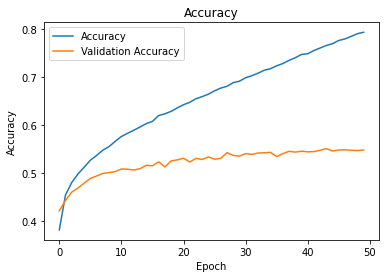

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Validation Accuracy'], loc='upper left')
plt.savefig("resources/Accuracy.png")
plt.show()

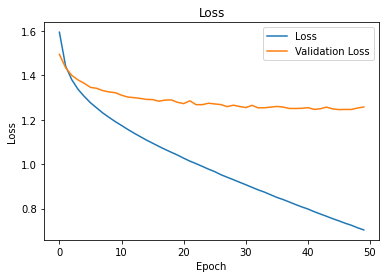

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Validation Loss'], loc='upper right')
plt.savefig("resources/Loss.png")
plt.show()

# Saving the model

In [13]:
model.save("detect.h5")

# Testing

In [14]:
p=model.evaluate(xtestpri,ytestpri)

113/113 [==============================] - 1s 11ms/step - loss: 1.2289 - accuracy: 0.5553
